## import libraries

In [1]:
# mount drive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install tmdbsimple

In [3]:
import os

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf


from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

import requests 
import tmdbsimple as tmdb
os.chdir('/content/gdrive/My Drive/IMT574_grader')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## load data

In [4]:
api_key = 'e0a83b0832c5748a239251f6fc4b3b3b'

columns = ['film', 'revenue', 'budget', 'release_date', "popularity", "production_countries", "runtime", "original_language", "vote_average"]
film_2020_df = pd.DataFrame(columns=columns)

for i in range(1,105):
    response = requests.get('https://api.themoviedb.org/3/discover/movie?api_key=' +  api_key + '&primary_release_year=2020&sort_by=revenue.desc&page=' + str(i))
    film_temp = response.json()
    film_temp= film_temp['results']

    temp_df = pd.DataFrame(columns=columns)
    for film in film_temp:
        # print(film['title'])
        film_revenue = requests.get('https://api.themoviedb.org/3/movie/'+ str(film['id']) +'?api_key='+ api_key+'&language=en-US')
        film_revenue = film_revenue.json()
        #print(film_revenue["production_countries"][0]["name"])
        #country = film_revenue["production_countries"][0]["name"] if film_revenue["production_countries"] != [] else ""
        temp_df.loc[len(temp_df)]=[film['title'],film_revenue['revenue'], (film_revenue['budget'] * -1), film_revenue['release_date'],
                                   film_revenue['popularity'], film_revenue["production_countries"], film_revenue['runtime'],
                                   film_revenue['original_language'], film_revenue['vote_average']]
    film_2020_df = film_2020_df.append(temp_df, ignore_index=True)

In [5]:
film_2020_df.shape

(2080, 9)

In [6]:
film_2020_df.to_pickle("./film_2020_df.pkl")

## preprocess data
### prepare features

In [7]:
film_2020_df.dtypes

film                     object
revenue                  object
budget                   object
release_date             object
popularity              float64
production_countries     object
runtime                  object
original_language        object
vote_average            float64
dtype: object

In [9]:
film_2020_df['gross'] = film_2020_df['revenue'] + film_2020_df['budget']
film_2020_df['num_country'] = film_2020_df['production_countries'].apply(lambda x:len(x))
film_2020_df['release_date'] = pd.to_datetime(film_2020_df['release_date'], format='%Y-%m-%d')
film_2020_df["month"] = film_2020_df['release_date'].dt.to_period('M')

film_2020_df.head()

,film,revenue,budget,release_date,popularity,production_countries,runtime,original_language,vote_average,gross,num_country,month
0,The Eight Hundred,460919368,-80000000,2020-08-14,17.136,"[{'iso_3166_1': 'CN', 'name': 'China'}]",147,zh,7.3,380919368,1,2020-08
1,Metallica: WorldWired Tour - Live in Mancheste...,426900000,0,2020-06-08,3.600,[],150,en,0.0,426900000,0,2020-06
2,Bad Boys for Life,426505244,-90000000,2020-01-15,589.678,"[{'iso_3166_1': 'US', 'name': 'United States o...",124,en,7.2,336505244,1,2020-01
3,Demon Slayer - Kimetsu no Yaiba - The Movie: M...,399180000,0,2020-10-16,192.974,"[{'iso_3166_1': 'JP', 'name': 'Japan'}]",117,ja,8.1,399180000,1,2020-10
4,Tenet,363129000,-205000000,2020-08-22,621.490,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",150,en,7.3,158129000,2,2020-08


In [10]:
film_2020_df.revenue = film_2020_df.revenue.astype('int')
film_2020_df.budget = film_2020_df.budget.astype('int')
film_2020_df.gross = film_2020_df.gross.astype('int')
film_2020_df.runtime = film_2020_df.runtime.astype('int')

## build models

Correlation analysis

In [11]:
film_2020_df.dtypes

film                            object
revenue                          int64
budget                           int64
release_date            datetime64[ns]
popularity                     float64
production_countries            object
runtime                          int64
original_language               object
vote_average                   float64
gross                            int64
num_country                      int64
month                        period[M]
dtype: object

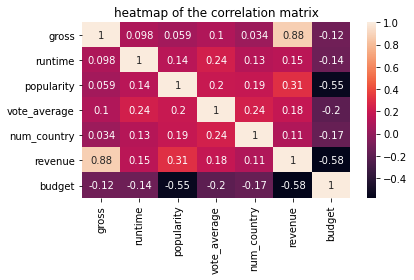

In [12]:
corr_matrix = film_2020_df[['gross', 'runtime','popularity', 'vote_average', 'num_country', 'revenue', 'budget']].corr()
plot1 = sns.heatmap(corr_matrix, annot=True)
plot1.set_title("heatmap of the correlation matrix")
plt.tight_layout()

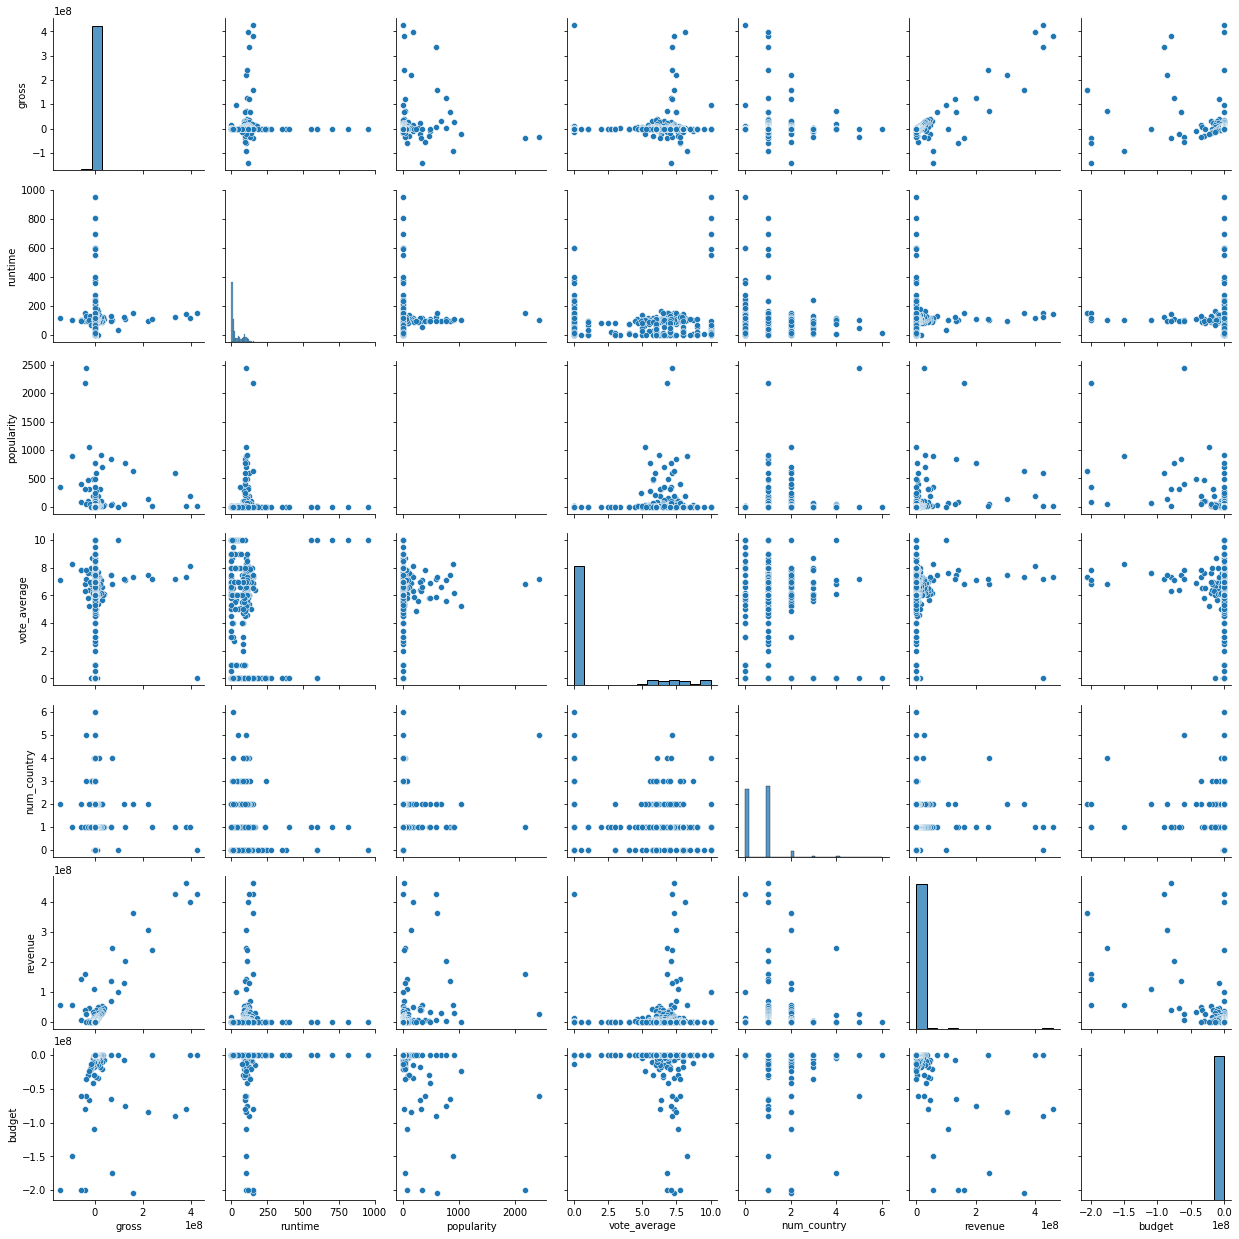

In [13]:
sns.pairplot(film_2020_df[['gross', 'runtime','popularity', 'vote_average', 'num_country', 'revenue', 'budget']])
plt.show()

#### Linear Regression

In [14]:
X = film_2020_df[['runtime','popularity', 'vote_average']]
X = sm.add_constant(X)
X = X.astype(float)
y = film_2020_df[['gross']]
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     12.45
Date:                Mon, 22 Mar 2021   Prob (F-statistic):           4.57e-08
Time:                        23:47:34   Log-Likelihood:                -37914.
No. Observations:                2080   AIC:                         7.584e+04
Df Residuals:                    2076   BIC:                         7.586e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -4.539e+05   5.35e+05     -0.848      0.396    -1.5e+06    5.96e+05
runtime       2.604e+04   7863.425      3.311      0.001    1.06e+04    4.15e+04
popularity    7043.9126   4748.829      1.483      0.138   -2269.051    1.64e+04
vote_average  5.436e+05   1.54e+05      3.530      0.000    2.42e+05    8.46e+05
==============================================================================
Omnibus:                     4035.900   Durbin-Watson:                   0.421
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6828240.115
Skew:                          14.929   Prob(JB):                         0.00
Kurtosis:                     282.098   Cond. No.                         118.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Model comparison between models with different independent variables

In [15]:
X = film_2020_df[['popularity']]
X = sm.add_constant(X)
X = X.astype(float)
y = film_2020_df[['budget']]
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 budget   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     882.0
Date:                Mon, 22 Mar 2021   Prob (F-statistic):          7.33e-162
Time:                        23:47:47   Log-Likelihood:                -36443.
No. Observations:                2080   AIC:                         7.289e+04
Df Residuals:                    2078   BIC:                         7.290e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.593e+05   2.17e+05     -2.114      0.035   -8.85e+05   -3.32e+04
popularity -6.786e+04   2284.787    -29.699      0.000   -7.23e+04   -6.34e+04
==============================================================================
Omnibus:                     3632.486   Durbin-Watson:                   1.473
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4302964.805
Skew:                         -11.895   Prob(JB):                         0.00
Kurtosis:                     224.548   Cond. No.                         95.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### classification

In [16]:
film_2020_df.describe()

,revenue,budget,popularity,runtime,vote_average,gross,num_country
count,2.080000e+03,2.080000e+03,2080.000000,2080.000000,2080.000000,2.080000e+03,2080.000000
mean,2.514980e+06,-1.207451e+06,11.025689,35.876442,1.378894,1.307529e+06,0.609135
std,2.454312e+07,1.174312e+07,94.469409,57.634571,2.972245,2.013518e+07,0.671421
min,0.000000e+00,-2.050000e+08,0.000000,0.000000,0.000000,-1.430000e+08,0.000000
25%,0.000000e+00,0.000000e+00,0.600000,3.000000,0.000000,0.000000e+00,0.000000
50%,0.000000e+00,0.000000e+00,0.600000,13.000000,0.000000,0.000000e+00,1.000000
75%,0.000000e+00,0.000000e+00,0.749500,59.000000,0.000000,0.000000e+00,1.000000
max,4.609194e+08,0.000000e+00,2440.254000,954.000000,10.000000,4.269000e+08,6.000000


In [17]:
#df['gross_group'] = pd.cut(df['gross'], bins=5, labels=labels)
film_2020_df['gross_group'] = film_2020_df['gross'].apply(lambda x: 1 if x> 0 else 0) #1:+; 0:-
film_2020_df['gross_group'].value_counts()

0    1885
1     195
Name: gross_group, dtype: int64

In [18]:
X = film_2020_df[['runtime','popularity', 'vote_average']]
y = film_2020_df['gross_group']

acc_list = []
for i in range(100):
    #Creating X and Y for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

    rfc = RandomForestClassifier(n_estimators=100)

    rfc.fit(X_train, y_train.values.ravel())

    predictions = rfc.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    acc_list.append(accuracy)

df_acc = pd.DataFrame(acc_list, columns = ["accuracy"])
df_acc.describe()

,accuracy
count,100.000000
mean,0.951779
std,0.006626
min,0.932692
25%,0.948718
50%,0.951923
75%,0.956731
max,0.969551
